In [1]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

# Importing Data

In [2]:
train1 = pd.read_csv('train_abusive.csv')
train2 = pd.read_csv('train_nonabusive.csv')
train3 = pd.read_csv('test_abusive.csv')
train4 = pd.read_csv('test_nonabusive.csv')

In [3]:
len(train2) + len(train4)

2009

# Data Pre-processing

In [4]:
train = pd.concat([train1,train2,train3,train4])

In [5]:
train.reset_index(drop = True)
train['label'] = train['label'].fillna(0)

In [6]:
train = train.sample(frac = 1)

In [7]:
final_dataset = train[['comment','label']].copy()
final_dataset.head(10)

,comment,label
359,I m proud to be a muslim there is no god accep...,0.0
352,what the shit pizza is that? bread and cheese?...,1.0
492,"Holy shit, he got the voice down to a tee.",1.0
272,How fucking great is this that it’s the DEMOCR...,1.0
735,Before he learned that she is the state attorn...,0.0
201,I love how they always play victim,0.0
250,Who’s here from Kate’s Elizabeth Warren impres...,0.0
948,white privlage?,0.0
360,Im proud of my new religion reverted from Chri...,0.0
1063,Fatty should get more ours on the job so time ...,0.0


In [8]:
X = train['comment'].astype(str)
Y = train['label'].astype(int)

X = X.values
Y = Y.values

In [9]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(X)):
    print(i,end = '\r')
    review = re.sub('[^a-zA-Z]', ' ', X[i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

# Creating Model

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import numpy as np
from sklearn.model_selection import train_test_split

In [11]:
def create_model(embedding_vector_features, sent_length):
    model=Sequential()
    model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
    model.add(Dropout(0.5))
    model.add(LSTM(128,return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(256,return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(512,return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(512,return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

### Final Data Pre-processing

In [12]:
voc_size = 100000
embedding_vector_features=128
sent_length=200

In [13]:
onehot_repr=[one_hot(word,voc_size)for word in corpus]

In [14]:
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[    0     0     0 ... 16810 20038 67319]
 [    0     0     0 ... 57960 38923 33072]
 [    0     0     0 ... 80727 27423 82548]
 ...
 [    0     0     0 ... 65487 65487 19904]
 [    0     0     0 ... 61804 13315 70438]
 [    0     0     0 ... 97345 76571 29562]]


In [15]:
len(embedded_docs)

3979

In [16]:
X_final=np.array(embedded_docs)
y_final=np.array(Y)

X_final.shape,y_final.shape

((3979, 200), (3979,))

### Data Splitting

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=42)

In [18]:
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

In [19]:
model = create_model(embedding_vector_features, sent_length)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          12800000  
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 200, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 200, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 200, 256)          394240    
                                                                 
 dropout_2 (Dropout)         (None, 200, 256)          0         
                                                                 
 lstm_2 (LSTM)               (None, 200, 512)          1

In [21]:
from tensorflow.keras.utils import plot_model

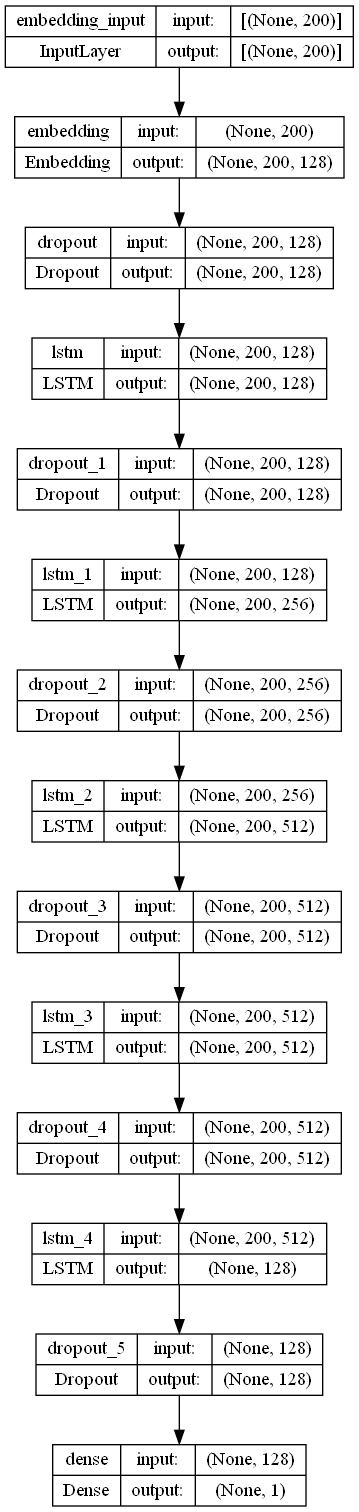

In [22]:
plot_model(model,to_file = 'model.png',show_shapes = True)

### Model Training

In [23]:
model_history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10)

Epoch 1/10
56/56 [==============================] - 54s 744ms/step - loss: 0.6941 - accuracy: 0.5140 - val_loss: 0.6855 - val_accuracy: 0.5737
Epoch 2/10
56/56 [==============================] - 48s 873ms/step - loss: 0.6073 - accuracy: 0.6693 - val_loss: 0.4953 - val_accuracy: 0.7521
Epoch 3/10
56/56 [==============================] - 81s 1s/step - loss: 0.2756 - accuracy: 0.8894 - val_loss: 0.3036 - val_accuracy: 0.8827
Epoch 4/10
56/56 [==============================] - 24s 429ms/step - loss: 0.1213 - accuracy: 0.9631 - val_loss: 0.2667 - val_accuracy: 0.9070
Epoch 5/10
56/56 [==============================] - 53s 949ms/step - loss: 0.0523 - accuracy: 0.9860 - val_loss: 0.3245 - val_accuracy: 0.9229
Epoch 6/10
56/56 [==============================] - 41s 733ms/step - loss: 0.0374 - accuracy: 0.9894 - val_loss: 0.3192 - val_accuracy: 0.9154
Epoch 7/10
56/56 [==============================] - 24s 437ms/step - loss: 0.0298 - accuracy: 0.9944 - val_loss: 0.3526 - val_accuracy: 0.9255
Ep

# Performance Testing

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

In [25]:
y_pred=model.predict(X_test)

32/32 [==============================] - 5s 79ms/step


In [26]:
print(model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Training Visualization

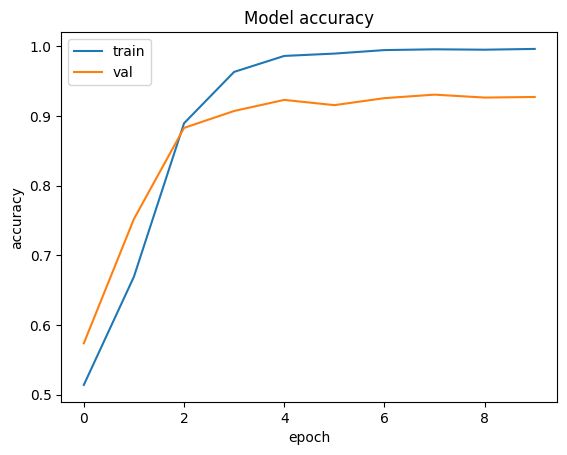

In [27]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.savefig('Training Accuracy')
plt.show()

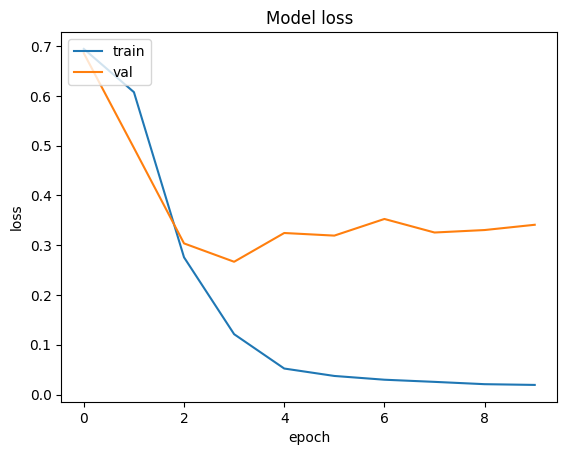

In [28]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

## ROC Curve

In [29]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)

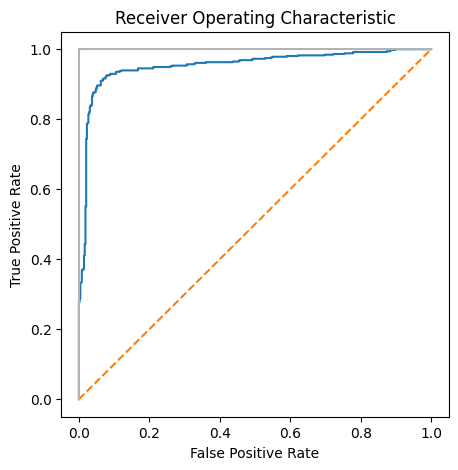

In [30]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC Curve')
plt.show()

In [31]:
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

roc_auc_score:  0.9537315605590062


## Confusion Matrix

In [32]:
y_ = [1 if x>0.9 else 0 for x in y_pred]

In [33]:
cm = confusion_matrix(y_test,y_)
cm

array([[460,  23],
       [ 63, 449]], dtype=int64)

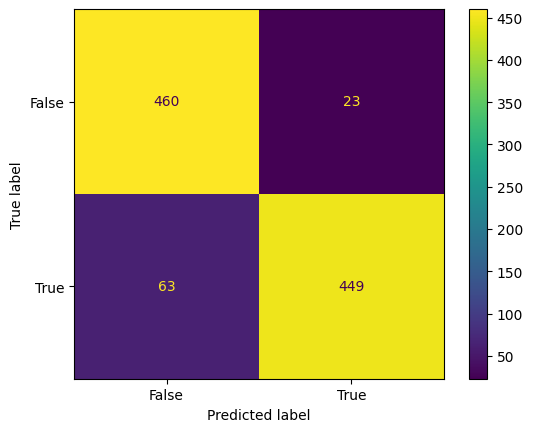

In [34]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.savefig('Confusion Matrix')
plt.show()

In [35]:
accuracy_score(y_test,y_)

0.91356783919598

# Saving Model

In [36]:
model.save('final_model.h5')

# Loading Model for Real Time Testing

In [37]:
import keras
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

ps = PorterStemmer()
loaded_model = keras.models.load_model('final_model.h5')

In [38]:
voc_size = 100000
embedding_vector_features=128
sent_length=200

onehot_repr=[one_hot(word,voc_size)for word in corpus]

In [39]:
def prediction(test,inp_model):
    test = re.sub('[^a-zA-Z]', ' ', test)
    test = test.lower()
    test = test.split()
    
    test = [ps.stem(word) for word in test if not word in stopwords.words('english')]
    test = ' '.join(test)
    
    
    test_one_hot = one_hot(test,100000)
    l = len(test_one_hot)
    if l<200:
        pad = 200 - l
        a = [0 for x in range(pad)]
        a.extend(test_one_hot)
        test = np.array(a)
        test = test.reshape(-1,200)
    else:
        test_one_hot = test_one_hot[:200]
        test = np.array(test_one_hot)
        test = test.reshape(-1,200)
        
    ans = inp_model.predict(test)
    if ans>0.7:
        print('Hate Speech Detected')
    else:
        print('Positive speech detected')

In [40]:
x = input('Enter String: ')
x = prediction(x,loaded_model)

Enter String:  'Blacks are too stupid and/or incapable to get state IDs, that is why we cannot allow Republicans to enforce requiring a state ID to be able to vote. Blacks are too stupid and incompetent to make it to college on their own, that is why we need affirmative action for everything.


1/1 [==============================] - 2s 2s/step
Hate Speech Detected


Hate Speech Example: 'Blacks are too stupid and/or incapable to get state IDs, that is why we cannot allow Republicans to enforce requiring a state ID to be able to vote. Blacks are too stupid and incompetent to make it to college on their own, that is why we need affirmative action for everything.'

positive speech Example: 'So he ran her tags and nothing came back?  He said he never saw this happen before so that's why he stopped her. Well that and tinted windows... which he didn't have the mechanism to measure it and said so. Then he said they were running the tags now ... he didn't say "again". What am I missing here?'

In [41]:
from keras.utils.vis_utils import plot_model

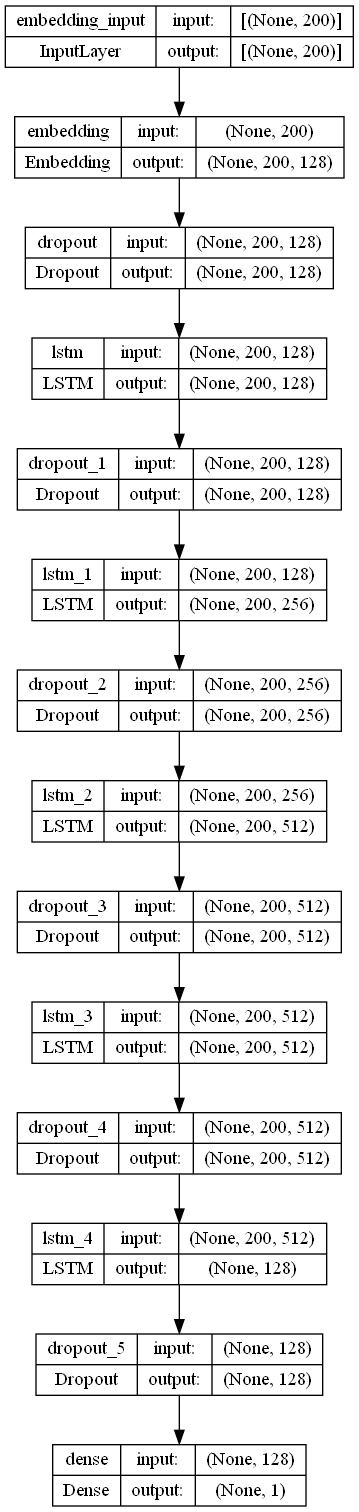

In [42]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)